# Library installation

In [1]:
# Google Colab
# !pip install -q kaggle datasets Pillow huggingface_hub wandb
# !pip install -q diffusers[training]

# Dataset acquisition

In [2]:
# from google.colab import files
# files.upload()

In [3]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# !kaggle datasets download -d maysee/mushrooms-classification-common-genuss-images -p /content/data --unzip

# Necessary dependencies

In [5]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import wandb

# Viewing a sample

In [6]:
files=glob.glob("data/raw/Mushrooms/*/*.*",recursive=True)


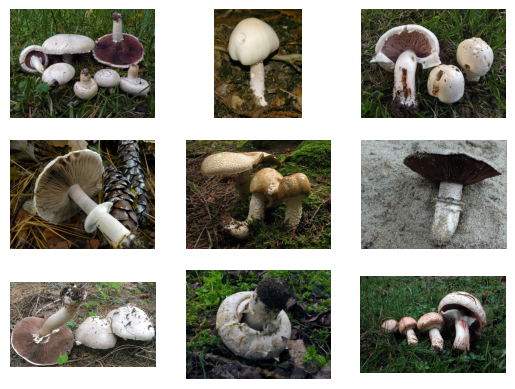

In [7]:
size_dataset=len(files)
sample=np.random.randint(0,size_dataset,9)
for index,filename in enumerate(sample):
    img=plt.imread(files[index])
    plt.subplot(3,3,index+1)
    plt.imshow(img)
    plt.axis('off')

In [8]:
from datasets import Dataset, Image

/home/mgalicia/miniconda3/envs/deep_l_04/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset creation

In [9]:
dataset=Dataset.from_dict({'image':files}).cast_column("image", Image())

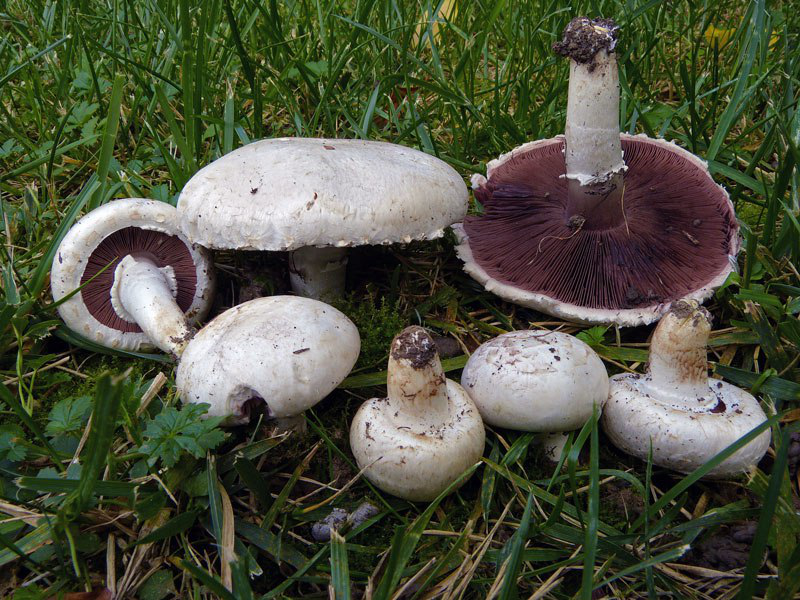

In [10]:
dataset[0]['image']

In [11]:
dataset

Dataset({
    features: ['image'],
    num_rows: 6714
})

In [12]:
from dataclasses import dataclass

# Training configuration

In [13]:
@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 1000
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-mushrooms-128"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [14]:
dataset

Dataset({
    features: ['image'],
    num_rows: 6714
})

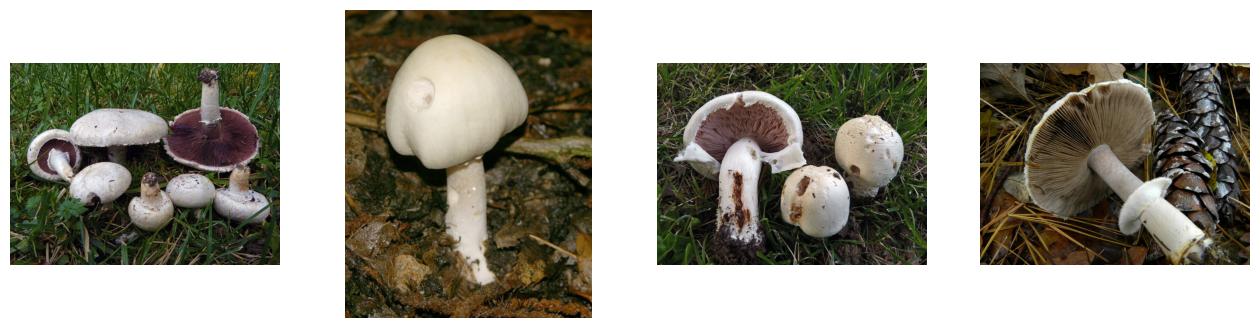

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

# Apply transformations and preprocessing

In [16]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [17]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

In [18]:
dataset[0]['images'].shape

torch.Size([3, 128, 128])

# Create a dataloader

In [19]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

# Create UNet Model

In [20]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

## Check input and output shapes

In [21]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


In [22]:
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


# Set a scheduler

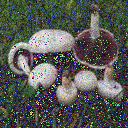

In [23]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

# Set a loss function

In [24]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

# Set the optimizer

In [25]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [26]:
from diffusers import DDPMPipeline
import math
import os


def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

# Train loop

In [27]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import os


def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_on_server")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

# Train

In [28]:
from accelerate import notebook_launcher

In [29]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True #Solve problem: OSError: image file is truncated (92 bytes not processed)

In [30]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


Epoch 49: 100%|██████████| 420/420 [02:37<00:00,  2.67it/s, loss=0.00639, lr=5.55e-12, step=20999]


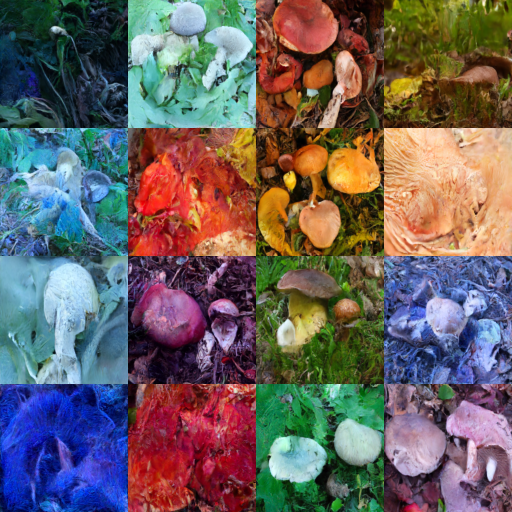

In [31]:
sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

# Load model and metrics to the Hub

In [35]:
from huggingface_hub import notebook_login

notebook_login()

In [36]:
from huggingface_hub import HfApi
api = HfApi()

api.upload_folder(
    folder_path="ddpm-mushrooms-128/",
    repo_id="MexicanVanGogh/ddpm-mushrooms-128",
    repo_type="model",
)


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]
events.out.tfevents.1701317325.proyectosrym.2907530.0: 100%|██████████| 2.68M/2.68M [00:00<00:00, 4.12MB/s]
diffusion_pytorch_model.safetensors: 100%|██████████| 455M/455M [00:14<00:00, 31.8MB/s]
Upload 2 LFS files: 100%|██████████| 2/2 [00:14<00:00,  7.27s/it]


'https://huggingface.co/MexicanVanGogh/ddpm-mushrooms-128/tree/main/'

In [37]:
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

100%|██████████| 50/50 [00:00<00:00, 100.43it/s]


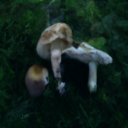

In [56]:
image = pipeline(num_inference_steps=50).images[0]
image

# Check inference

In [ ]:
from diffusers import DDPMPipeline

model_id = "MexicanVanGogh/ddpm-mushrooms-128"

ddpm = DDPMPipeline.from_pretrained(model_id, use_safetensors=True).to("cuda")
image = ddpm(num_inference_steps=25).images[0]
image

In [ ]:
image = ddpm(num_inference_steps=80).images[0]
image